In [0]:
import os ; os.chdir('/content/drive/My Drive/Colab Notebooks/Lazy courses/Markov Models')

initial A: [[0.75403048 0.24596952]
 [0.43162236 0.56837764]]
initial R: [[0.5 0.5]
 [0.5 0.5]]
it: 0
it: 1
it: 2
it: 3
it: 4


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:94: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


it: 5
it: 6
it: 7
it: 8
it: 9
it: 10
it: 11
it: 12
it: 13
it: 14
it: 15
it: 16
it: 17
it: 18
it: 19
it: 20
it: 21
it: 22
it: 23
it: 24
it: 25
it: 26
it: 27
it: 28
it: 29
A: [[0.89078907 0.10921093]
 [0.70893649 0.29106351]]
mu: [[[ 0.19448178]
  [-0.58084667]]

 [[-0.08238134]
  [-0.60589042]]]
sigma: [[[[1.74282029]]

  [[0.13454621]]]


 [[[1.39276293]]

  [[1.22692489]]]]
R: [[0.73959693 0.26040307]
 [0.47096522 0.52903478]]
pi: [0.65874541 0.34125459]


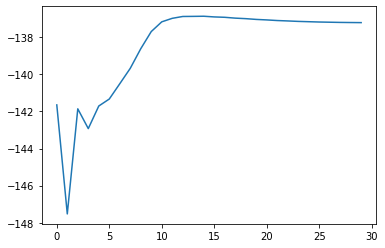

LL for fitted params -137.21018929076465
LL for actual params: -135.98123341288735
Most likely state sequence for initial observation:
[0 0 0 0 0 0 0 0 0 0]


In [8]:
import wave
import numpy as np
import matplotlib.pyplot as plt

from generate_hmmc_data import get_signals, big_init, simple_init
from scipy.stats import multivariate_normal as mvn

def random_normalized(d1, d2):
    x = np.random.random((d1, d2))
    return x / x.sum(axis=1, keepdims=True)

class HMM:
    def __init__(self, M, K):
        self.M = M #number of hidden states
        self.K = K #number of Gaussians 

    def fit(self, X, max_iter=30, eps=1e0):
        #train the HMM model using the Baum Welch algorithm
        #a specific instance of the expectation-maximization algorithm

        N = len(X)
        D = X[0].shape[1] #assume each x is organized (T, D)

        self.pi = np.ones(self.M) / self.M #initial state distribution
        self.A = random_normalized(self.M, self.M) #state transition matrix
        self.R = np.ones((self.M, self.K)) /self.K #gaussian mixture proportions
        print('initial A:', self.A)
        print('initial R:', self.R)
        self.mu = np.zeros((self.M, self.K, D))
        for i in range(self.M):
            for k in range(self.K):
                random_idx = np.random.choice(N)
                x = X[random_idx]
                random_time_idx = np.random.choice(len(x))
                self.mu[i,k] = x[random_time_idx]
        self.sigma = np.zeros((self.M, self.K, D, D))
        for j in range(self.M):
            for k in range(self.K):
                self.sigma[j,k] = np.eye(D)

        costs = []
        for it in range(max_iter):
            if it % 1 == 0:
                print('it:', it)
            alphas = []
            betas = []
            gammas = []
            Bs = []
            P = np.zeros(N)

            for n in range(N):
                x = X[n]
                T = len(x)

                #Calculate B so we can lookup when updating alpha and beta
                B = np.zeros((self.M, T))
                component = np.zeros((self.M, self.K, T)) #we will need these later
                for j in range(self.M):
                    for t in range(T):
                        for k in range(self.K):
                            p = self.R[j,k] * mvn.pdf(x[t], self.mu[j,k], self.sigma[j,k])
                            component[j,k,t] = p
                            B[j,t] += p
                Bs.append(B)

                alpha = np.zeros((T, self.M))
                alpha[0] = self.pi*B[:,0]
                for t in range(1, T):
                    alpha[t] = alpha[t-1].dot(self.A) * B[:,t]
                P[n] = alpha[-1].sum()
                assert(P[n] <= 1)
                alphas.append(alpha)

                beta = np.zeros((T, self.M))
                beta[-1] = 1
                for t in range(T - 2, -1, -1):
                    beta[t] = self.A.dot(B[:,t+1] * beta[t+1])
                betas.append(beta)

                #update the gaussians
                gamma = np.zeros((T, self.M, self.K))
                for t in range(T):
                    alphabeta = (alphas[n][t,:] * betas[n][t,:]).sum()
                    for j in range(self.M):
                        factor = alphas[n][t,j] * betas[n][t,j] / alphabeta
                        for k in range(self.K):
                            gamma[t,j,k] = factor * component[j,k,t] / B[j,t]
                gammas.append(gamma)

            cost = np.log(P).sum()
            costs.append(cost)
            
            #now re-estimate pi, A, R, mu, sigma
            self.pi = np.sum((alphas[n][0] * betas[n][0])/P[n] for n in range(N)) / N

            a_den = np.zeros((self.M, 1))
            a_num = 0
            r_num = np.zeros((self.M, self.K))
            r_den = np.zeros(self.M)
            mu_num = np.zeros((self.M, self.K, D))
            sigma_num = np.zeros((self.M, self.K, D, D))
            for n in range(N):
                x = X[n]
                T = len(x)
                B = Bs[n]
                gamma = gammas[n]

                #denominator for A
                a_den += (alphas[n][:-1] * betas[n][:-1]).sum(axis=0, keepdims=True).T / P[n]
                

                #numerator for A
                a_num_n = np.zeros((self.M, self.M))
                for i in range(self.M):
                    for j in range(self.M):
                        for t in range(T-1):
                            a_num_n[i,j] += alphas[n][t,i] * self.A[i,j] * B[j,t+1] * betas[n][t+1,j]
                a_num += a_num_n / P[n]

                #update mixture components
                r_num_n = np.zeros((self.M, self.K))
                r_den_n = np.zeros(self.M)
                for j in range(self.M):
                    for k in range(self.K):
                        for t in range(T):
                            r_num_n[j,k] += gamma[t,j,k]
                            r_den_n[j] += gamma[t,j,k]
                r_num += r_num_n / P[n]
                r_den += r_den_n / P[n]

                mu_num_n = np.zeros((self.M, self.K, D))
                sigma_num_n = np.zeros((self.M, self.K, D, D))
                for j in range(self.M):
                    for k in range(self.K):
                        for t in range(T):
                            #update means
                            mu_num_n[j,k] += gamma[t,j,k] * x[t]

                            #update covariances
                            sigma_num_n[j,k] += gamma[t,j,k] * np.outer(x[t] - self.mu[j,k], x[t] - self.mu[j,k])
                mu_num += mu_num_n / P[n]
                sigma_num += sigma_num_n / P[n]

            self.A = a_num / a_den
            assert(np.all(self.A <= 1))
 
            #update R, mu, sigma
            for j in range(self.M):
                for k in range(self.K):
                    self.R[j,k] = r_num[j,k] / r_den[j]
                    self.mu[j,k] = mu_num[j,k] / r_num[j,k]
                    self.sigma[j,k] = sigma_num[j,k] / r_num[j,k]

        print("A:", self.A)
        print("mu:", self.mu)
        print("sigma:", self.sigma)
        print("R:", self.R)
        print("pi:", self.pi)

        plt.plot(costs)
        plt.show()

    def likelihood(self, x):
        #returns log P(x | model)
        #using the forward part of the forward-backward algorithm
        T = len(x)
        alpha = np.zeros((T, self.M))

        B = np.zeros((self.M, T))
        for j in range(self.M):
            for t in range(T):
                for k in range(self.K):
                    p = self.R[j,k] * mvn.pdf(x[t], self.mu[j,k], self.sigma[j,k])
                    B[j,t] += p

        alpha[0] = self.pi*B[:,0]
        for t in range(1, T):
            alpha[t] = alpha[t-1].dot(self.A) * B[:,t]
        return alpha[-1].sum()

    def get_state_sequence(self, x):
        #returns the most likely state sequence given observed sequence x
        #using the Viterbi algorithm
        T = len(x)

        #make the emmission matrix B
        B = np.zeros((self.M, T))
        for j in range(self.M):
            for t in range(T):
                for k in range(self.K):
                    p = self.R[j,k] * mvn.pdf(x[t], self.mu[j,k], self.sigma[j,k])
                    B[j,t] += p

        #perform Viterbi as usual
        delta = np.zeros((T, self.M))
        psi = np.zeros((T, self.M))
        delta[0] = self.pi*B[:,0]
        for t in range(1, T):
            for j in range(self.M):
                delta[t,j] = np.max(delta[t-1]*self.A[:,j]) * B[j,t]
                psi[t,j] = np.argmax(delta[t-1]*self.A[:,j])

        #backtrack
        states = np.zeros(T, dtype=np.int32)
        states[T-1] = np.argmax(delta[T-1])
        for t in range(T-2, -1, -1):
            states[t] = psi[t+1, states[t+1]]
        return states

    def likelihood_multi(self, X):
        return np.array([self.likelihood(x) for x in X])

    def log_likelihood_multi(self, X):
        return np.log(self.likelihood_multi(X))

    def set(self, pi, A, R, mu, sigma):
        self.pi = pi
        self.A = A
        self.R = R
        self.mu = mu
        self.sigma = sigma
        M, K = R.shape
        self.M = M
        self.K = K

def real_signal():
    spf = wave.open('helloworld.wav', 'r')

    #extract raw audio file from wav file
    #If we right click on the file and go to "get info", we can see
    #sampling rate = 16000Hz
    #bits per sample = 16
    #The first is quantization in time
    #The second is quantization in amplitude
    #Same is done for images
    #2^16 = 65536 is how many differnt sound levels we have

    signal = spf.readframes(-1)
    signal = np.fromstring(signal, 'Int16')
    T = len(signal)

    hmm = HMM(10)
    hmm.fit(signal.reshape(1, T))

def fake_signal(init=simple_init):
    signals = get_signals(N=10, T=10, init=init)

    hmm = HMM(2, 2)
    hmm.fit(signals)
    L = hmm.log_likelihood_multi(signals).sum()
    print("LL for fitted params", L)

    #test in actual params
    _, _, _, pi, A, R, mu, sigma = init()
    hmm.set(pi, A, R, mu, sigma)
    L = hmm.log_likelihood_multi(signals).sum()
    print("LL for actual params:", L)

    #print most likely state sequence
    print("Most likely state sequence for initial observation:")
    print(hmm.get_state_sequence(signals[0]))

if __name__ == '__main__':
    #real_signal() will break
    fake_signal(init=simple_init)
    #fake_signal(init=big_init) #will break